In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.stock_profile_core import StockProfile
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import os
import random
from utils.io import save_as_pkl, load_as_pkl
import seaborn as sns

# Raw DataFrame
<br><font color='green' size=3>
In this part, we try to get a first view of the dataset we are dealing with, checking out the statistics and characteristics of the dataset. The dataset is from https://www.kaggle.com/datasets/paultimothymooney/stock-market-data, with stock market price for companies in forbes2000, nasdaq, nyse, sp500. The primary purpose of this dataset was for stock market price prediction.
</font>

In [3]:
market = ['forbes2000', 'nasdaq', 'nyse', 'sp500']
print('Number of samples')
for m in market:
    print('{}: {}'.format(m, len(os.listdir(f'./data/stock_market_data/{m}/csv'))))

Number of samples
forbes2000: 1076
nasdaq: 1564
nyse: 1145
sp500: 409


In [4]:
stock_profile_ex1 = pd.read_csv('./data/stock_market_data/nasdaq/csv/AAL.csv')
stock_profile_ex1

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940
...,...,...,...,...,...,...,...
4328,06-12-2022,14.000000,14.140000,20781500,14.340000,14.330000,14.330000
4329,07-12-2022,13.530000,14.240000,28161400,14.240000,13.550000,13.550000
4330,08-12-2022,13.380000,13.650000,25300900,13.800000,13.600000,13.600000
4331,09-12-2022,13.420000,13.520000,18489800,13.660000,13.530000,13.530000


In [5]:
stock_profile_ex1.describe()

,Low,Open,Volume,High,Close,Adjusted Close
count,4333.000000,4333.000000,4.333000e+03,4333.000000,4333.000000,4333.000000
mean,24.942728,25.441034,1.437767e+07,25.909785,25.414123,24.446005
std,15.708710,15.905032,2.196850e+07,16.091603,15.904091,15.236068
min,1.450000,1.810000,1.385000e+05,2.030000,1.760000,1.659225
25%,10.640000,10.950000,4.610600e+06,11.210000,10.930000,10.341874
50%,21.770000,22.170000,7.441400e+06,22.480000,22.150000,21.570000
75%,38.910000,39.599998,1.332340e+07,40.180000,39.540001,37.851078
max,62.000000,62.700001,4.286171e+08,63.270000,62.950001,59.345573


<br><font color='green' size=3>
Unsurprised to see the correlation matrix with mostly 1's, since same day stock price high's and lows are highly correlated to each other. 
</font>

                     Low      Open    Volume      High     Close  \
Low             1.000000  0.999460 -0.221232  0.999391  0.999571   
Open            0.999460  1.000000 -0.216203  0.999563  0.999000   
Volume         -0.221232 -0.216203  1.000000 -0.211482 -0.216780   
High            0.999391  0.999563 -0.211482  1.000000  0.999543   
Close           0.999571  0.999000 -0.216780  0.999543  1.000000   
Adjusted Close  0.999069  0.998391 -0.205142  0.998843  0.999368   

                Adjusted Close  
Low                   0.999069  
Open                  0.998391  
Volume               -0.205142  
High                  0.998843  
Close                 0.999368  
Adjusted Close        1.000000  


<AxesSubplot:>

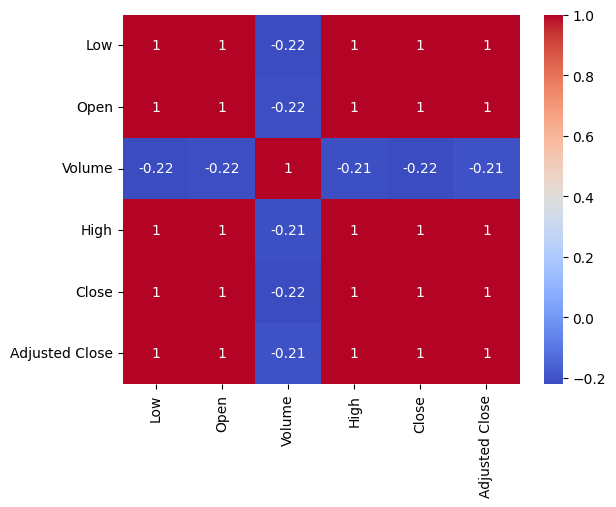

In [6]:
print(stock_profile_ex1.corr())
sns.heatmap(stock_profile_ex1.corr(), annot=True, cmap='coolwarm')

<br><font color='green' size=3>
Check the date difference between rows. This is important. We need to make sure the time series data is following a chronological order and the difference of days between each consecutive rows also needs to be checked. Normally, we need to take extra steps to clean up this later.
</font>

In [7]:
stock_profile_ex1['Date'] = pd.to_datetime(stock_profile_ex1['Date'], format='%d-%m-%Y', dayfirst=True)
diff_dates_row = stock_profile_ex1['Date'].diff()
print(diff_dates_row)

0         NaT
1      1 days
2      1 days
3      1 days
4      3 days
        ...  
4328   1 days
4329   1 days
4330   1 days
4331   1 days
4332   3 days
Name: Date, Length: 4333, dtype: timedelta64[ns]


In [8]:
list(diff_dates_row.head())

[NaT,
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('3 days 00:00:00')]

<br><font color='green' size=3>
For the purpose of our own application, we primarily focus on 'Open' and 'Close' columns.
</font>

Text(0, 0.5, 'Stock Price')

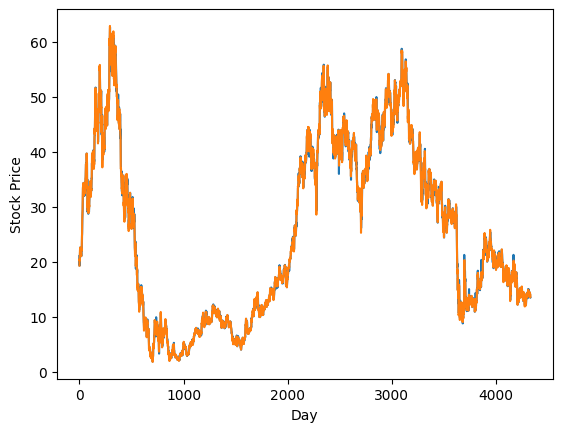

In [33]:
plt.plot(stock_profile_ex1['Open'])
plt.plot(stock_profile_ex1['Close'])
plt.xlabel('Day')
plt.ylabel('Stock Price')

Text(0, 0.5, 'Stock Price Difference (Same Day)')

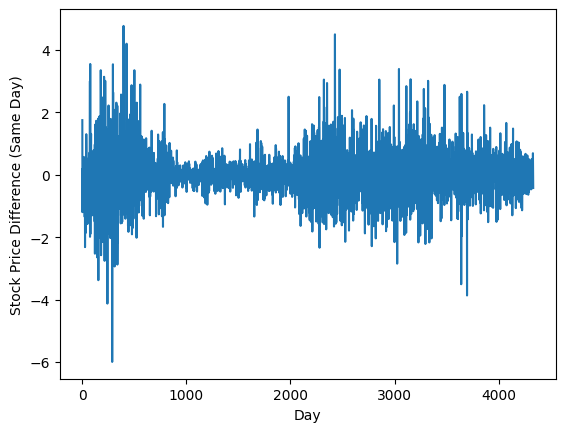

In [35]:
plt.plot(stock_profile_ex1['Open']-stock_profile_ex1['Close'])
plt.xlabel('Day')
plt.ylabel('Stock Price Difference (Same Day)')

# Data Cleaning and Preprocessing
<br><font color='green' size=3>
The pre-processing is wrapped in the StockProfile class. First of all, duplicated dates are removed and reformatted, then we upsampled to make the consecutive dates in a strict chronological order. We then applied linear interpolation in time series for the missing values.
</font>

In [ ]:
class StockProfile:
    
    def __init__(self, stock_df):
        self.stock_df = stock_df
        self._preprocess()
    
    def _preprocess(self):
        """
        Basic Preprocessing steps for raw stock dataframe. Procedures involve, 
        1. Remove duplicated samples based on date
        2. Conversion of obj type to datetime and float
        3. Upsample to full time span with time-series linear interpolation 
        """
        columns_names = self.stock_df.columns.values
        assert('Date' in columns_names), "Input stock dataframe must contain column Date"
        interpo_logs = {}

        # Remove duplicated Date
        self.stock_df.drop_duplicates(subset='Date', keep='first', inplace=True)
        self.stock_df['Date'] = pd.to_datetime(self.stock_df['Date'], format='%d-%m-%Y', dayfirst=True)
        
        first_date, last_date = self.stock_df.iloc[0]['Date'], self.stock_df.iloc[-1]['Date']

        # Upsample
        reinterpolated_df = pd.DataFrame(columns=columns_names)
        reinterpolated_df['Date'] = pd.bdate_range(start=first_date, end=last_date)
        reinterpolated_df.loc[reinterpolated_df['Date'].isin(self.stock_df['Date']), columns_names[1:]] = self.stock_df.loc[self.stock_df['Date'].isin(reinterpolated_df['Date']), columns_names[1:]].values
        
        reinterpolated_df = reinterpolated_df.set_index('Date')
        for i in columns_names[1:]:
            reinterpolated_df[i] = pd.to_numeric(reinterpolated_df[i])
        interpo_logs['nan_count'] = reinterpolated_df.isna().sum()
        interpo_logs['prior_interpo'] = np.asarray(reinterpolated_df)

        # Linear interpolate based on time
        self.stock_df = reinterpolated_df.interpolate('time')
        interpo_logs['after_interpo'] = np.asarray(reinterpolated_df)
    
    def get_marginal_profit_on_n_day_trading(self, trade_window, mode='percentage'):
        return compute_marginal_profit(np.asarray(self.stock_df['Open']).flatten(), 
                                       np.asarray(self.stock_df['Close']).flatten(),
                                       trade_window, mode)

# Approaches
<br><font color='green' size=3>
Assumptions:</font>
<br><font color='green' size=3>1. Optimal trading frequency is based on historical record from 1999-2022 purely. That means no other features or attributes are taken into the consideration</font>
<br><font color='green' size=3>2. We assume no inflation rate in our base model. This is a simplificiaton, because theoratically a marginal profit of 10% tomorrow is different from a margianl profit of 10% in 10 years. We will discuss the next step to put inflation rate into consideration in future work</font>
<br><font color='green' size=3>3. Recommandation is provided for universal traders. That means not to a specific stock buyer. 
</font>

<br><font color='green' size=3>
More info in README
</font>

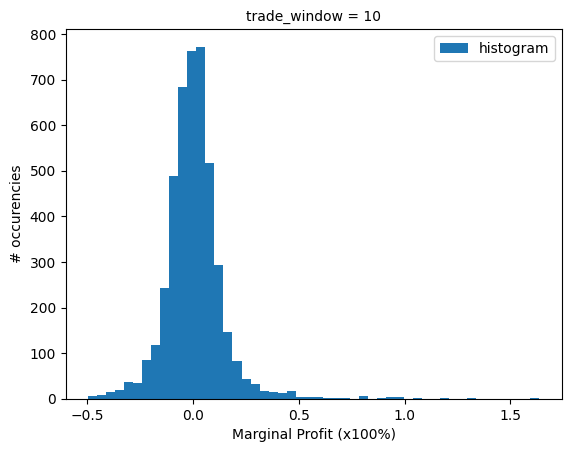

In [85]:
stock_profile = StockProfile(pd.read_csv('./data/stock_market_data/nasdaq/csv/AAL.csv'))
marginal_profit = stock_profile.get_marginal_profit_on_n_day_trading(trade_window = 10)
plt.hist(marginal_profit, bins=50, label='histogram')
plt.xlabel('Marginal Profit (x100%)')
plt.ylabel('# occurencies')
plt.title('trade_window = 10', fontsize=10)
plt.legend(loc='upper right')


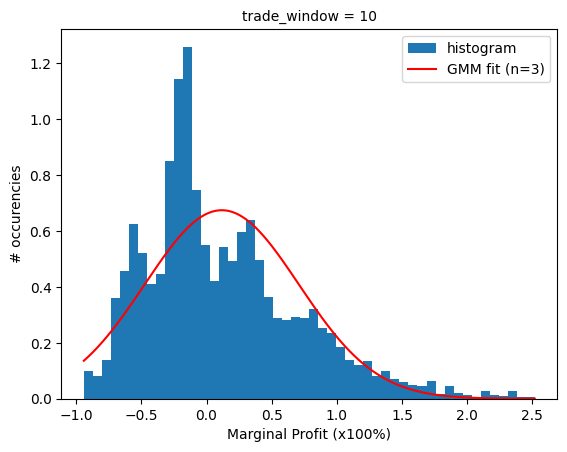

In [84]:
gmm = GaussianMixture(n_components=1)
gmm.fit(marginal_profit.reshape(-1, 1))

x = np.linspace(marginal_profit.min(), marginal_profit.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
plt.hist(marginal_profit, bins=50, density=True, label='histogram')
plt.plot(x[:, 0], np.exp(logprob), 'r', label='GMM fit (n={})'.format(3))
plt.xlabel('Marginal Profit (x100%)')
plt.ylabel('# occurencies')
plt.title('trade_window = 10', fontsize=10)
plt.legend(loc='upper right')
plt.show()

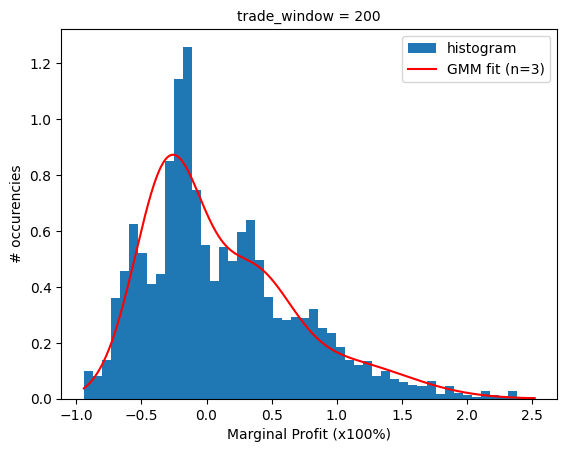

In [82]:
stock_profile = StockProfile(pd.read_csv('./data/stock_market_data/nasdaq/csv/AAL.csv'))
marginal_profit = stock_profile.get_marginal_profit_on_n_day_trading(trade_window = 200)
gmm = GaussianMixture(n_components=3)
gmm.fit(marginal_profit.reshape(-1, 1))

x = np.linspace(marginal_profit.min(), marginal_profit.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
plt.hist(marginal_profit, bins=50, density=True, label='histogram')
plt.plot(x[:, 0], np.exp(logprob), 'r', label='GMM fit (n={})'.format(3))
plt.xlabel('Marginal Profit (x100%)')
plt.ylabel('# occurencies')
plt.title('trade_window = 200', fontsize=10)
plt.legend(loc='upper right')
plt.show()

<br><font color='green' size=3>
Training is done with auto hyperparameter tuning using AIC. More details, see train.py
</font>

In [87]:
# Generate sample result figures for README
# training with auto tuning
current_stock = StockProfile(pd.read_csv('./data/stock_market_data/sp500/csv/HD.csv'))
counter = 0
for trade_window in range(1, 3650, 5):
    marginal_profit = current_stock.get_marginal_profit_on_n_day_trading(trade_window, mode='percentage')
    aic = []
    for n in range(1, 5):
        gmm = GaussianMixture(n_components=n)
        gmm.fit(marginal_profit.reshape(-1, 1))
        aic.append(gmm.aic(marginal_profit.reshape(-1, 1)))
    best_n = np.argmin(aic) + 1

    gmm = GaussianMixture(n_components=best_n)
    gmm.fit(marginal_profit.reshape(-1, 1))

    x = np.linspace(marginal_profit.min(), marginal_profit.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    plt.hist(marginal_profit, bins=50, density=True, label='histogram')
    plt.plot(x[:, 0], np.exp(logprob), 'r', label='GMM fit (n={})'.format(best_n))
    plt.xlabel('Marginal Profit (x100%)')
    plt.ylabel('# occurencies')
    plt.title('trade_window = {} days'.format(trade_window), fontsize=10)
    plt.legend(loc='upper right')
    plt.savefig('./test/{}.png'.format(counter))
    plt.clf()
    counter += 1

<Figure size 640x480 with 0 Axes>

In [ ]:
# Generate sample result figures for README
# training with auto tuning
current_stock = StockProfile(pd.read_csv('./data/stock_market_data/sp500/csv/HD.csv'))
counter = 0
for trade_window in range(1, 3650, 5):
    marginal_profit = current_stock.get_marginal_profit_on_n_day_trading(trade_window, mode='percentage')
    aic = []
    aic_test = []
    for n in range(1, 5):
        gmm = GaussianMixture(n_components=n)
        gmm.fit(marginal_profit.reshape(-1, 1))
        aic.append(gmm.aic(marginal_profit.reshape(-1, 1)))
    best_n = np.argmin(aic) + 1

    gmm = GaussianMixture(n_components=best_n)
    gmm.fit(marginal_profit.reshape(-1, 1))
    aic_test.append(gmm.aic(marginal_profit.reshape(-1, 1)))
    

In [90]:
gmm.aic(marginal_profit.reshape(-1, 1))

55516.73853162514

# Ensamble and Argmax of Probability

100%|████████████████████████████████████████| 731/731 [00:02<00:00, 296.75it/s]


Text(0, 0.5, 'marginal profit at highest probabiliy \nin ensambled GMM (x100%)')

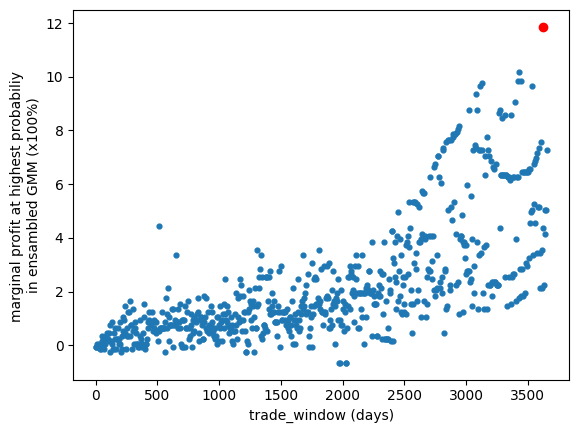

In [4]:
from ensamble import ensamble_GMM, CONFIG

x = np.linspace(-50, 50, 1000).reshape(-1, 1)
logprob_ensamble = ensamble_GMM(x)
result_summary = np.zeros((len(logprob_ensamble.keys()), 2))
for i, trade_window in enumerate(logprob_ensamble.keys()):
    result_summary[i, 0] = trade_window
    result_summary[i, 1] = x[np.argmax(np.exp(logprob_ensamble[trade_window]))]
    
best_trade_window = result_summary[np.argmax(result_summary[:, 1]), :]
    
plt.scatter(result_summary[:, 0], result_summary[:, 1], marker='o', s=12)
plt.scatter(best_trade_window[0], best_trade_window[1], c='r')
plt.xlabel('trade_window (days)')
plt.ylabel('marginal profit at highest probabiliy \nin ensambled GMM (x100%)')